# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

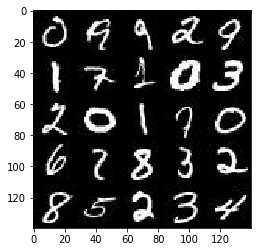

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

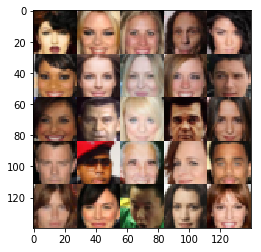

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [54]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=None, name="learning_rate")    
    return (inputs_real, inputs_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        relu2_shape = relu2.get_shape().as_list()
        

        # Flatten it
        flat = tf.reshape(relu2, (-1, relu2_shape[1]*relu2_shape[2]*relu2_shape[3]))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [64]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images*2})


                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images*2})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4035... Generator Loss: 6.0971
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 3.5961... Generator Loss: 0.0972
Epoch 1/2... Discriminator Loss: 2.7380... Generator Loss: 0.1391
Epoch 1/2... Discriminator Loss: 2.5379... Generator Loss: 0.1649
Epoch 1/2... Discriminator Loss: 2.1950... Generator Loss: 0.1975
Epoch 1/2... Discriminator Loss: 2.1224... Generator Loss: 0.2059
Epoch 1/2... Discriminator Loss: 1.9802... Generator Loss: 0.2430
Epoch 1/2... Discriminator Loss: 1.7876... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 1.7746... Generator Loss: 0.3329


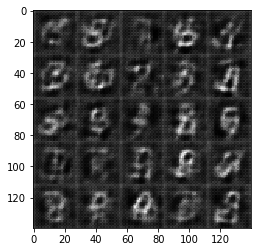

Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.6674... Generator Loss: 0.3495
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.4523
Epoch 1/2... Discriminator Loss: 1.7477... Generator Loss: 0.3307
Epoch 1/2... Discriminator Loss: 1.6618... Generator Loss: 0.3701
Epoch 1/2... Discriminator Loss: 1.6369... Generator Loss: 0.3638
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.4507
Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 0.3614
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 1.6580... Generator Loss: 0.3509


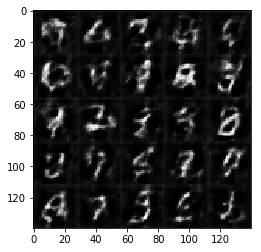

Epoch 1/2... Discriminator Loss: 1.5628... Generator Loss: 0.4131
Epoch 1/2... Discriminator Loss: 1.6479... Generator Loss: 0.3561
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.5663... Generator Loss: 0.3956
Epoch 1/2... Discriminator Loss: 1.7047... Generator Loss: 0.3345
Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.4194
Epoch 1/2... Discriminator Loss: 1.7194... Generator Loss: 0.3296


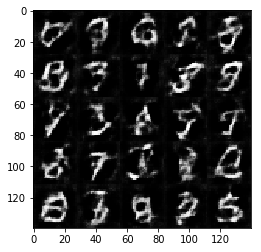

Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 1.5640... Generator Loss: 0.3901
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.4810
Epoch 1/2... Discriminator Loss: 1.6233... Generator Loss: 0.3724
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 1.6459... Generator Loss: 0.3490
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 1.1363
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 1.5725
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 1.4013
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 1.2509


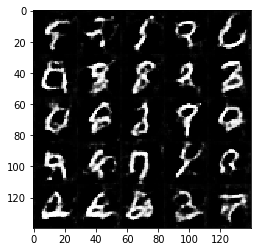

Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 1.4296
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 1.2285
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 1.1543
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 1.2381
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 1.5891
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 1.6254... Generator Loss: 0.3543
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.4635


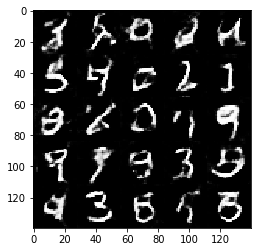

Epoch 1/2... Discriminator Loss: 1.4773... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 3.3326... Generator Loss: 3.6407
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 1.1875
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 1.0171
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.9772


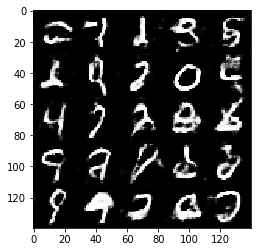

Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 1.3886
Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 1.0015
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 1.2426
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 1.4040
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 1.4280
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.5080
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.5038


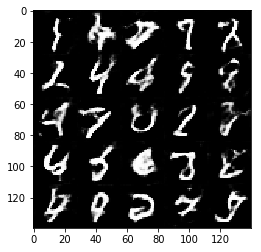

Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.4093
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.5410
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.4502
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.4682
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.7083
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.4612


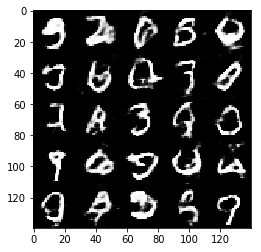

Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.4786
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.4769... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 1.9383
Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 1.4490
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 1.5592
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 1.2111


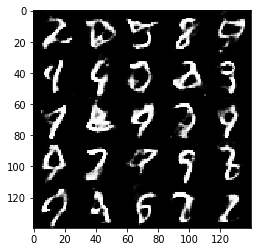

Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 1.5394
Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 2.5554
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 1.3673
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 1.5135
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 1.2452
Epoch 2/2... Discriminator Loss: 0.9752... Generator Loss: 1.1769
Epoch 2/2... Discriminator Loss: 1.5841... Generator Loss: 0.3957
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.7282


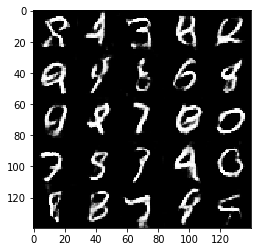

Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 2.0752... Generator Loss: 0.2256
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 1.6287
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 1.8588
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.1681
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 1.7974
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.6122


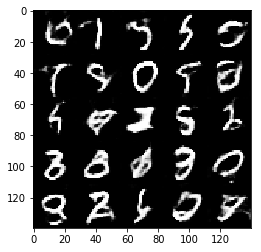

Epoch 2/2... Discriminator Loss: 1.0614... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.6878... Generator Loss: 0.3242
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 1.3429
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.4415
Epoch 2/2... Discriminator Loss: 1.8308... Generator Loss: 2.1078
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 1.6603
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 0.4495
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.5549


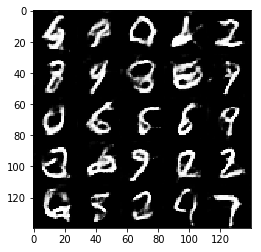

Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.7721
Epoch 2/2... Discriminator Loss: 1.0131... Generator Loss: 1.3482
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 1.8822
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 1.6392
Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 1.6036
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 1.9792
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 1.5477
Epoch 2/2... Discriminator Loss: 1.7021... Generator Loss: 0.3568


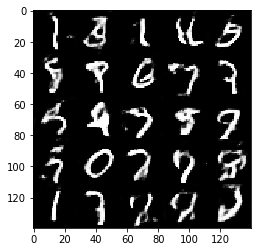

Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.5145... Generator Loss: 0.4302
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 1.3812
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.4757
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.5119
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 2.0096


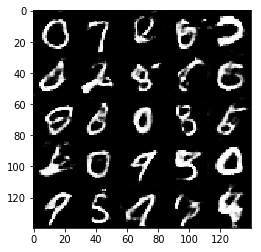

Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 1.9428
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 1.1894
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 1.7584
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 1.1198
Epoch 2/2... Discriminator Loss: 1.0489... Generator Loss: 1.9518
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.3325
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 1.7909
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 1.4248
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 1.5180


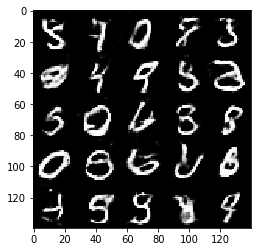

Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 1.9698... Generator Loss: 0.2502
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.5722
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 1.3140
Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 2.3750
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 1.9176


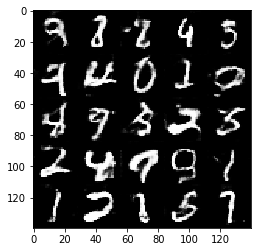

Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 1.9328
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.5718
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 2.4434
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.4164
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 2.0731
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 1.7296
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 1.2591
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 1.5844... Generator Loss: 0.3847
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.6239


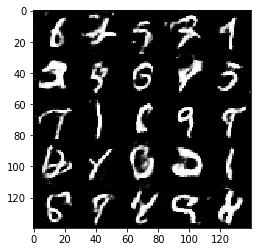

Epoch 2/2... Discriminator Loss: 1.4865... Generator Loss: 0.4357
Epoch 2/2... Discriminator Loss: 1.0179... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.4337... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.6588
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 1.2460
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 1.3238


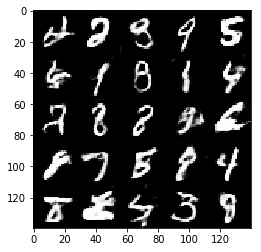

Epoch 2/2... Discriminator Loss: 0.8950... Generator Loss: 1.9845
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 2.0293
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 1.8438
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 1.0428
Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 1.5946
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.4969
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 2.2742


In [65]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 8.6240... Generator Loss: 0.0042
Epoch 1/1... Discriminator Loss: 4.8478... Generator Loss: 0.0372
Epoch 1/1... Discriminator Loss: 3.5820... Generator Loss: 0.0481
Epoch 1/1... Discriminator Loss: 2.9928... Generator Loss: 0.0869
Epoch 1/1... Discriminator Loss: 2.9582... Generator Loss: 0.0889
Epoch 1/1... Discriminator Loss: 2.5185... Generator Loss: 0.1564
Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 0.3792
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 2.5413... Generator Loss: 0.1409


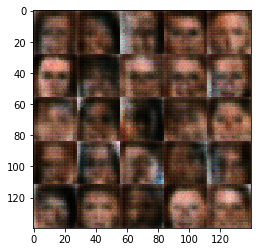

Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 2.0737
Epoch 1/1... Discriminator Loss: 1.9976... Generator Loss: 1.6622
Epoch 1/1... Discriminator Loss: 2.1430... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 2.0107... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 2.1261
Epoch 1/1... Discriminator Loss: 1.7485... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 1.4100
Epoch 1/1... Discriminator Loss: 2.0103... Generator Loss: 2.6191


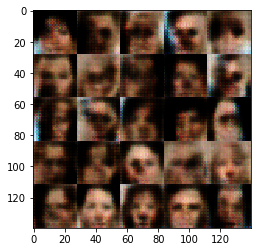

Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 2.3149
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.6999... Generator Loss: 2.3284
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 1.7930


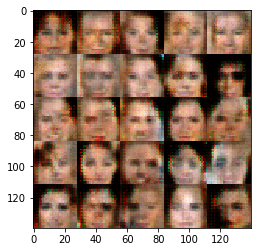

Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.8074... Generator Loss: 0.3182
Epoch 1/1... Discriminator Loss: 1.8993... Generator Loss: 0.3117
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6279


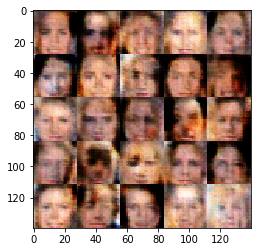

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.6609... Generator Loss: 0.3528
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.8721
Epoch 1/1... Discriminator Loss: 1.7784... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 0.2926
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 0.3205
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.0794


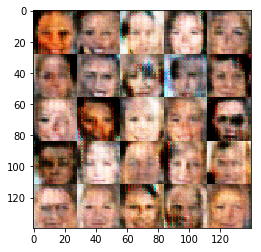

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.3696
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 1.3954


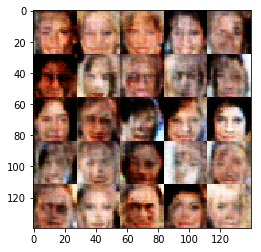

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.8977
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 1.7501... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.7080


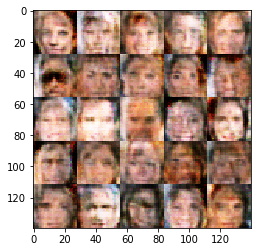

Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.6921


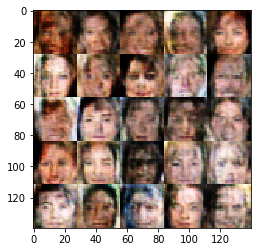

Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5673


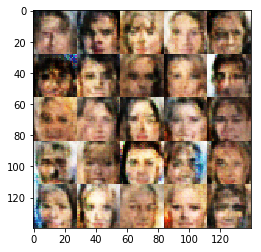

Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.6180... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8172


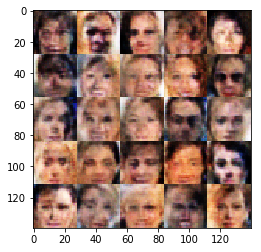

Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.7666... Generator Loss: 0.3343
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6651


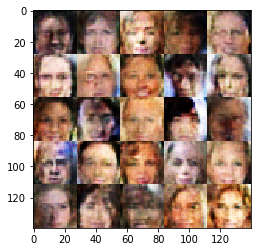

Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.7854... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.7816


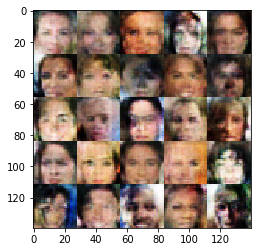

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.7776... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.5466


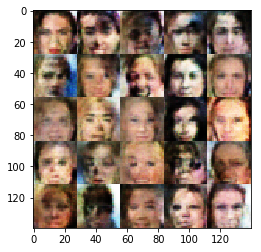

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.8602... Generator Loss: 0.3434
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.8837


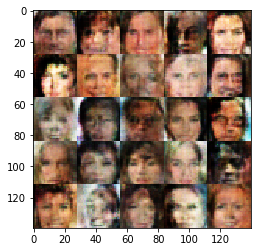

Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.5568


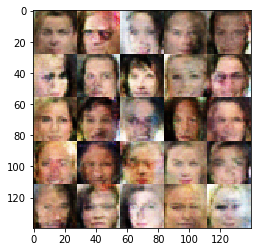

Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8102


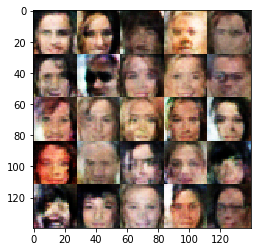

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.6704... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6440


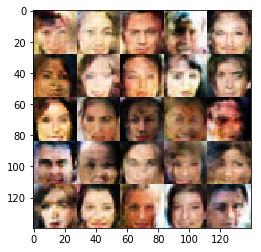

Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.5583


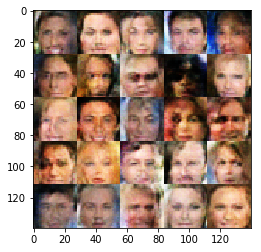

Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7687


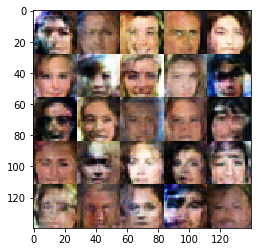

Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.9461... Generator Loss: 0.2579
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4744


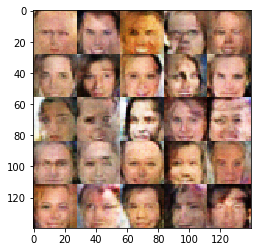

Epoch 1/1... Discriminator Loss: 1.6858... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7354


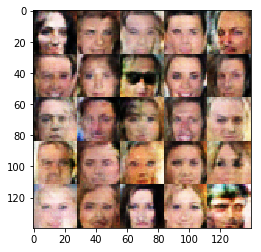

Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.7102... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.6688


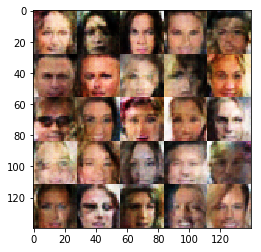

Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6992


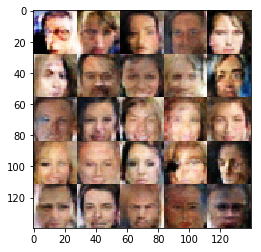

Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.6410... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6207


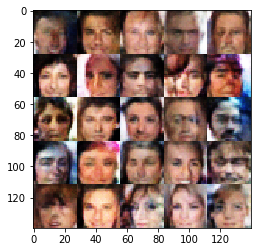

Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.7072... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6001


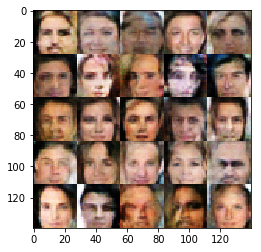

Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.7252


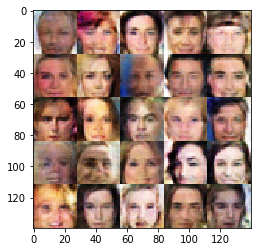

Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.6933


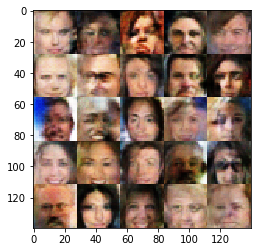

Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6340


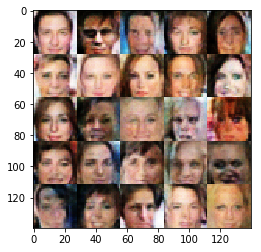

Epoch 1/1... Discriminator Loss: 1.6900... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.4111


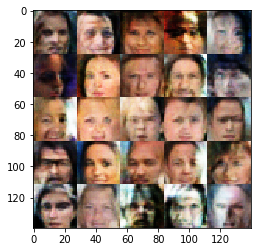

Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.6539... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.4822


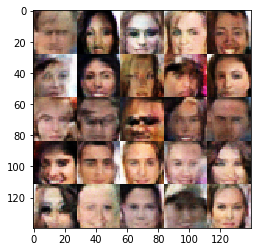

Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.9935


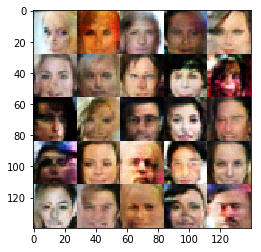

Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.4437


In [66]:
batch_size = 64
z_dim = 250
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.